# V3 34 x 34 - 4 Wool Colours

##### Image:

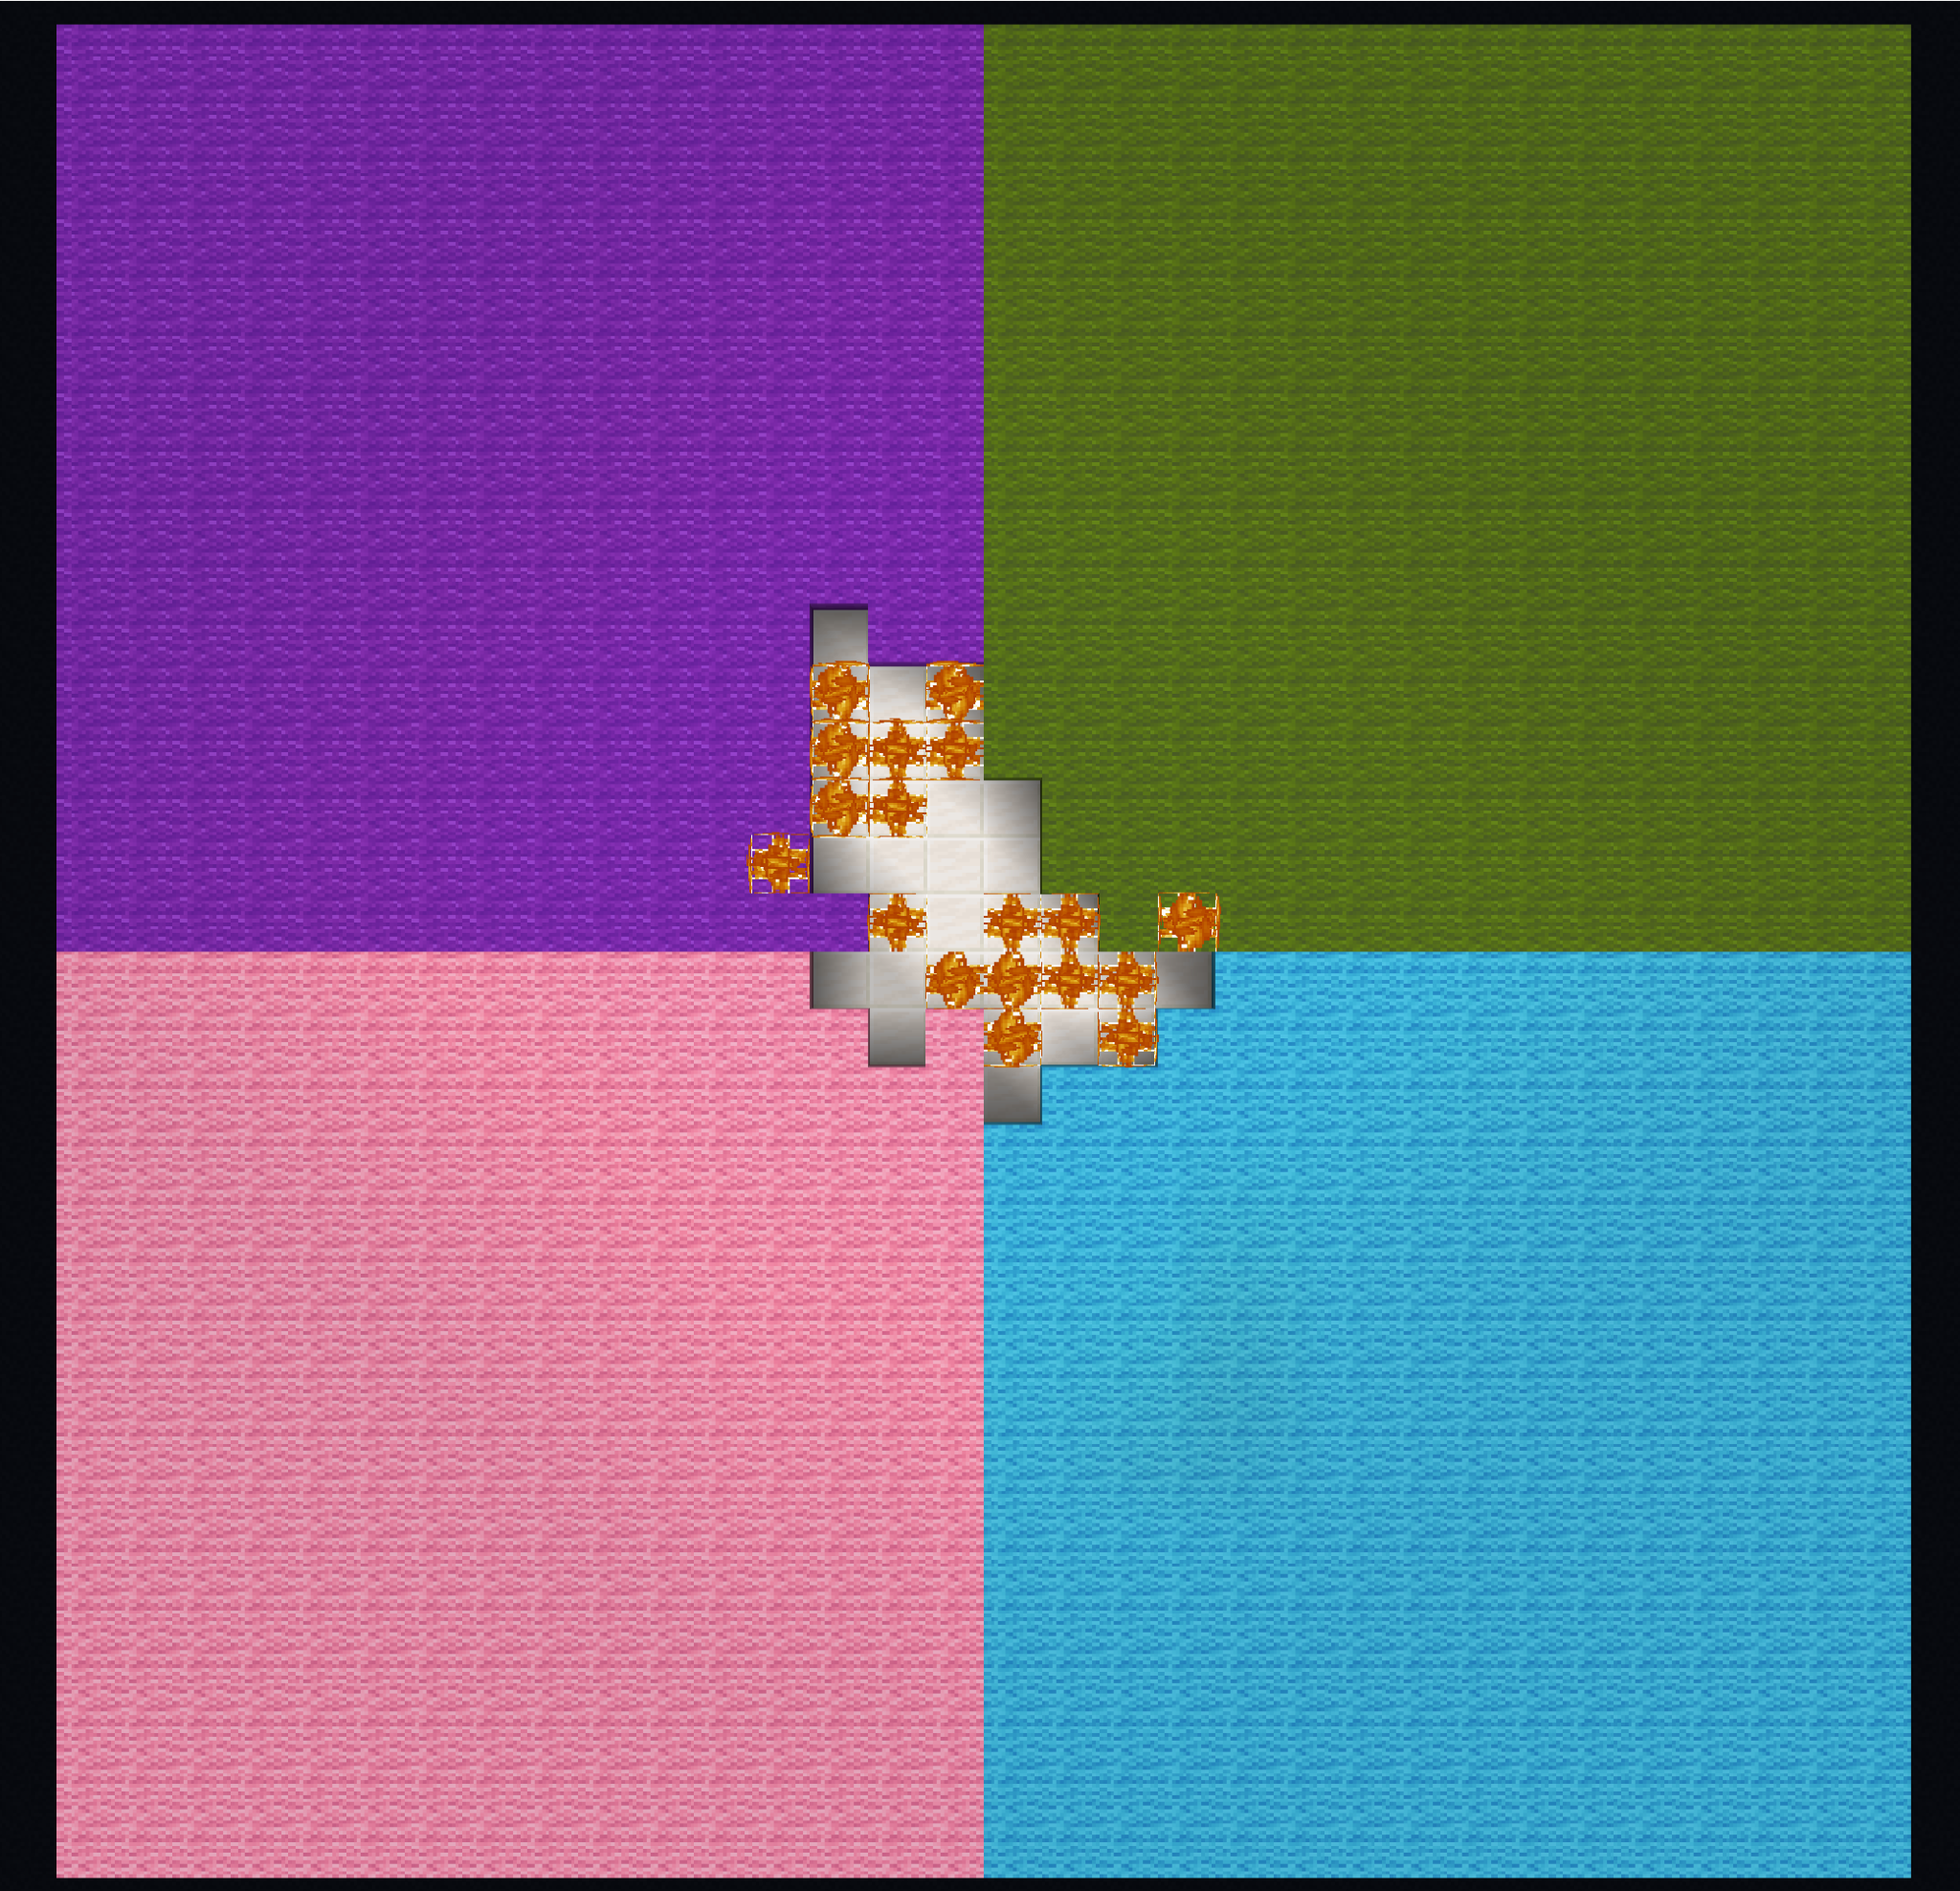

### Cell 1: Global Configuration & Imports

In [ ]:
# Cell 1: Global configuration & imports

# Global configuration
IMAGE_FOLDER = r"C:\Users\samih\Documents\ShareX\Screenshots\For VS Vision\34 x 34 - 4 Wool Colours Test Default"
images_folder = IMAGE_FOLDER

GRID_SIZE = 34
TIME_STEP = 1           # Time step between images in seconds
DEFAULT_IMAGE_STEP = 1 # Process every nth image (change as needed)

import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from IPython.display import HTML, display


### Cell 2: RAW Image Loading and Animation

In [ ]:
# def load_raw_images(images_folder, image_step=DEFAULT_IMAGE_STEP):
#     """
#     Load all RAW image files (PNG or JPG) from the folder sorted by modification time,
#     then subsample based on image_step.
#     """
#     image_paths = sorted(glob.glob(os.path.join(images_folder, "*.png")), key=os.path.getmtime)
#     if not image_paths:
#         image_paths = sorted(glob.glob(os.path.join(images_folder, "*.jpg")), key=os.path.getmtime)
#     image_paths = image_paths[::image_step]  # Subsample

#     images = []
#     for path in image_paths:
#         img = cv2.imread(path)
#         if img is None:
#             print(f"Warning: Could not load image {path}")
#         else:
#             img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             images.append(img_rgb)
#     if not images:
#         raise ValueError("No images were loaded. Check your folder path and file types.")
#     return images

# def animate_raw_images(images, image_step=DEFAULT_IMAGE_STEP):
#     """
#     Animate RAW images using Matplotlib.
#     Each frame is labeled as "Time = {t} seconds", where t = (frame index)*image_step.
#     """
#     fig, ax = plt.subplots()
#     im_plot = ax.imshow(images[0])
#     title = ax.set_title("Time = 0 seconds")
#     ax.axis('off')
    
#     def update(frame):
#         im_plot.set_data(images[frame])
#         time_label = frame * image_step
#         title.set_text(f"Time = {time_label} seconds")
#         return [im_plot, title]
    
#     anim = animation.FuncAnimation(fig, update, frames=len(images),
#                                    interval=500, blit=False, repeat=True)
#     display(HTML(anim.to_jshtml()))
#     plt.show()

# # Example usage for RAW images:
# raw_images = load_raw_images(images_folder, image_step=DEFAULT_IMAGE_STEP)
# animate_raw_images(raw_images, image_step=DEFAULT_IMAGE_STEP)


### Cell 3: Classification Functions

In [ ]:
def classify_cell_color(avg_bgr):
    """
    Classify a cell based on its average BGR color.
    
    Returns:
      'orange' if 0 <= H <= 40, S > 60, V > 60 (fire),
      'green' if 50 <= H <= 70, S > 80, V > 80 (wool green),
      'purple' if 130 <= H <= 160, S > 70, V > 50 (wool purple),
      'pink' if 160 <= H <= 180, S > 50, V > 100 (wool pink),
      'lightblue' if 80 <= H <= 100, S > 50, V > 80 (wool light blue),
      otherwise 'white'.
    """
    b, g, r = avg_bgr
    color_bgr = np.uint8([[avg_bgr]])
    hsv = cv2.cvtColor(color_bgr, cv2.COLOR_BGR2HSV)[0, 0]
    h, s, v = hsv
    
    # Check for fire (orange)

    # Check for wool green
    if (30 <= h <= 90) and (s > 50) and (v > 50):
        return 'green'
    # Check for wool purple
    elif (130 <= h <= 160) and (s > 70) and (v > 50):
        return 'purple'
    # Check for wool pink
    elif (160 <= h <= 180) and (s > 50) and (v > 100):
        return 'pink'
    # Check for wool light blue
    elif (80 <= h <= 100) and (s > 50) and (v > 80):
        return 'lightblue'
    elif (0 <= h <= 40) and (s > 60) and (v > 60):
        return 'orange'
    else:
        return 'white'

def process_image_into_grid(img, grid_size=GRID_SIZE):
    """
    Splits an image into a GRID_SIZE x GRID_SIZE grid.
    Outer border cells are forced to 'black'.
    Inner cells are classified using classify_cell_color() as described above.
    Returns:
      - A (GRID_SIZE x GRID_SIZE) NumPy array of labels.
      - A color-coded classification image (RGB; one pixel per cell).
    """
    height, width, _ = img.shape
    cell_h = height // grid_size
    cell_w = width // grid_size
    
    labels = []
    classified_img = np.zeros((grid_size, grid_size, 3), dtype=np.uint8)
    
    for row in range(grid_size):
        row_labels = []
        for col in range(grid_size):
            # Force outer border cells to black
            if row == 0 or row == grid_size - 1 or col == 0 or col == grid_size - 1:
                label = 'black'
            else:
                y_start = row * cell_h
                y_end = (row + 1) * cell_h
                x_start = col * cell_w
                x_end = (col + 1) * cell_w
                cell = img[y_start:y_end, x_start:x_end]
                avg_b = np.mean(cell[:, :, 0])
                avg_g = np.mean(cell[:, :, 1])
                avg_r = np.mean(cell[:, :, 2])
                label = classify_cell_color((avg_b, avg_g, avg_r))
            row_labels.append(label)
            
            # Map label to color (RGB)
            if label == 'black':
                classified_img[row, col] = (0, 0, 0)
            elif label == 'white':
                classified_img[row, col] = (255, 255, 255)
            elif label == 'orange':
                classified_img[row, col] = (255, 165, 0)
            elif label == 'green':
                classified_img[row, col] = (0, 255, 0)
            elif label == 'purple':
                classified_img[row, col] = (178, 69, 208)   # example purple
            elif label == 'pink':
                classified_img[row, col] = (255, 192, 203)   # example pink
            elif label == 'lightblue':
                classified_img[row, col] = (173, 216, 230)   # example light blue
            else:
                classified_img[row, col] = (127, 127, 127)   # fallback (gray)
        labels.append(row_labels)
    return np.array(labels), classified_img


### Cell 4: Classified Image Animation

In [ ]:
# def get_classified_images(images_folder, grid_size=GRID_SIZE, upscale_factor=10, image_step=DEFAULT_IMAGE_STEP):
#     """
#     Loads all images from the folder (subsampled by image_step), processes each into a grid,
#     and upscales the resulting classification image for display.
#     Returns a list of upscaled classified images.
#     """
#     image_paths = sorted(glob.glob(os.path.join(images_folder, "*.png")), key=os.path.getmtime)
#     if not image_paths:
#         image_paths = sorted(glob.glob(os.path.join(images_folder, "*.jpg")), key=os.path.getmtime)
#     image_paths = image_paths[::image_step]
    
#     classified_images = []
#     for path in image_paths:
#         img = cv2.imread(path)
#         if img is None:
#             continue
#         _, cls_img = process_image_into_grid(img, grid_size)
#         upscaled = cv2.resize(cls_img, (grid_size * upscale_factor, grid_size * upscale_factor),
#                               interpolation=cv2.INTER_NEAREST)
#         classified_images.append(upscaled)
#     return classified_images

# def animate_classified_images(classified_images, image_step=DEFAULT_IMAGE_STEP):
#     """
#     Animate a list of upscaled classified images.
#     Each frame is labeled "Time = {t} sec", where t = (frame index) * image_step.
#     """
#     fig, ax = plt.subplots()
#     im_plot = ax.imshow(classified_images[0])
#     title = ax.set_title("Time = 0 seconds")
#     ax.axis('off')
    
#     def update(frame):
#         im_plot.set_data(classified_images[frame])
#         time_label = frame * image_step
#         title.set_text(f"Time = {time_label} seconds")
#         return [im_plot, title]
    
#     anim = animation.FuncAnimation(fig, update, frames=len(classified_images),
#                                    interval=500, blit=False, repeat=True)
#     display(HTML(anim.to_jshtml()))
#     plt.show()

# # Example usage for classified image animation:
# classified_images = get_classified_images(images_folder, grid_size=GRID_SIZE,
#                                           upscale_factor=10, image_step=DEFAULT_IMAGE_STEP)
# animate_classified_images(classified_images, image_step=DEFAULT_IMAGE_STEP)


### Cell 5: Side‑by‑Side-by-Side Comparison (Original vs. Classified vs. Isochrone Images)

In [ ]:
def get_isochrone_contours(labels_grid, upscale_factor=10):
    """
    Create a binary mask from the classification grid for cells labeled 'orange' or 'white',
    upscale it, and find contours.
    """
    grid_size_local = labels_grid.shape[0]
    mask = np.zeros((grid_size_local, grid_size_local), dtype=np.uint8)
    for r in range(grid_size_local):
        for c in range(grid_size_local):
            if labels_grid[r, c] in ('orange', 'white'):
                mask[r, c] = 255
    upscaled_size = (grid_size_local * upscale_factor, grid_size_local * upscale_factor)
    mask_upscaled = cv2.resize(mask, upscaled_size, interpolation=cv2.INTER_NEAREST)
    contours, _ = cv2.findContours(mask_upscaled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def draw_isochrone_only(labels_grid, upscale_factor=10):
    """
    Create a blank white canvas and draw the isochrone contour (from 'orange'/'white' cells)
    using thin red lines.
    """
    grid_size_local = labels_grid.shape[0]
    upscaled_size = (grid_size_local * upscale_factor, grid_size_local * upscale_factor)
    contours = get_isochrone_contours(labels_grid, upscale_factor=upscale_factor)
    outline_img = 255 * np.ones((upscaled_size[1], upscaled_size[0], 3), dtype=np.uint8)
    if contours:
        cv2.drawContours(outline_img, contours, -1, (255, 0, 0), 1)
    return outline_img

def show_four_panel_comparison(images_folder, grid_size=GRID_SIZE, upscale_factor=10,
                               image_step=DEFAULT_IMAGE_STEP, blend_alpha=0.5):
    """
    For each (or every nth) image in the folder, display a figure with 4 panels:
      1. Original image (RGB)
      2. Classified image (upscaled)
      3. Overlay image: the downscaled original with the isochrone overlaid
      4. Isochrone-only image (upscaled)
    
    The time label is computed as "Time = t sec", where t = index * image_step.
    """
    # Get image file paths (PNG first, then JPG) and subsample.
    image_paths = sorted(glob.glob(os.path.join(images_folder, "*.png")), key=os.path.getmtime)
    if not image_paths:
        image_paths = sorted(glob.glob(os.path.join(images_folder, "*.jpg")), key=os.path.getmtime)
    if not image_paths:
        raise ValueError("No images found in the specified folder.")
    image_paths = image_paths[::image_step]
    
    for idx, path in enumerate(image_paths):
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Could not load image {path}")
            continue
        
        # Panel 1: Original image (RGB)
        orig_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Panel 2: Classified image
        labels_grid, cls_img = process_image_into_grid(img, grid_size)
        upscaled_classified = cv2.resize(cls_img, (grid_size * upscale_factor, grid_size * upscale_factor),
                                         interpolation=cv2.INTER_NEAREST)
        
        # Panel 3: Overlay image (Original downscaled + isochrone overlaid)
        # Downscale the original to match the classified resolution.
        new_width = grid_size * upscale_factor
        new_height = grid_size * upscale_factor
        orig_downscaled = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
        # Compute isochrone from the labels_grid using your earlier function.
        iso_img = draw_isochrone_only(labels_grid, upscale_factor=upscale_factor)
        # Blend the downscaled original and the isochrone image.
        overlayed = cv2.addWeighted(orig_downscaled, blend_alpha, iso_img, 1 - blend_alpha, 0)
        
        # Panel 4: Isochrone-only image
        iso_only = iso_img
        
        # Compute time label (first image is time = 0 sec)
        time_label = idx * image_step
        
        # Create a 4-panel figure.
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        axes[0].imshow(orig_rgb)
        axes[0].set_title(f"Original (Time = {time_label} sec)")
        axes[0].axis('off')
        
        axes[1].imshow(upscaled_classified)
        axes[1].set_title(f"Classified (Time = {time_label} sec)")
        axes[1].axis('off')
        
        axes[2].imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
        axes[2].set_title(f"Overlay (Time = {time_label} sec)")
        axes[2].axis('off')
        
        axes[3].imshow(cv2.cvtColor(iso_only, cv2.COLOR_BGR2RGB))
        axes[3].set_title(f"Isochrone Only (Time = {time_label} sec)")
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage:
show_four_panel_comparison(images_folder, grid_size=GRID_SIZE, upscale_factor=10,
                           image_step=DEFAULT_IMAGE_STEP, blend_alpha=0.5)


### Cell 6: Overlay of Isochrones (Color Gradient with Colorbar)

In [ ]:
def overlay_all_isochrones_color_gradient(images_folder, grid_size=GRID_SIZE, upscale_factor=10, 
                                          line_thickness=1, image_step=DEFAULT_IMAGE_STEP):
    """
    For all (or every nth) images in the folder, compute isochrone contours (from 'orange' or 'white' cells)
    and overlay them on a single white canvas using a color gradient.
    A colorbar maps the gradient to time (in seconds).
    """
    image_paths = sorted(glob.glob(os.path.join(images_folder, "*.png")), key=os.path.getmtime)
    if not image_paths:
        image_paths = sorted(glob.glob(os.path.join(images_folder, "*.jpg")), key=os.path.getmtime)
    if not image_paths:
        raise ValueError("No images found in the specified folder.")
    image_paths = image_paths[::image_step]
    
    cmap = cm.get_cmap('jet', len(image_paths))
    upscaled_size = (grid_size * upscale_factor, grid_size * upscale_factor)
    overlay_img = 255 * np.ones((upscaled_size[1], upscaled_size[0], 3), dtype=np.uint8)
    
    for i, path in enumerate(image_paths):
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Could not load image {path}")
            continue
        labels_grid, _ = process_image_into_grid(img, grid_size)
        contours = get_isochrone_contours(labels_grid, upscale_factor=upscale_factor)
        
        color_rgba = cmap(i)
        # Convert from RGBA (0-1) to BGR (0-255)
        color_bgr = (int(color_rgba[2]*255), int(color_rgba[1]*255), int(color_rgba[0]*255))
        if contours:
            cv2.drawContours(overlay_img, contours, -1, color_bgr, line_thickness)
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
    ax.set_title("Overlay of Isochrones (Color Gradient)")
    ax.axis('off')
    
    norm = plt.Normalize(vmin=0, vmax=(len(image_paths)-1)*image_step)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04,
                        ticks=np.linspace(0, (len(image_paths)-1)*image_step, num=len(image_paths)))
    cbar.set_label("Time (seconds)")
    
    plt.tight_layout()
    plt.show()

# Example usage:
overlay_all_isochrones_color_gradient(images_folder, grid_size=GRID_SIZE, upscale_factor=10,
                                      line_thickness=1, image_step=DEFAULT_IMAGE_STEP)


### Cell 7: Fire Spread Quantification and Plotting

In [ ]:
# DEFAULT_IMAGE_STEP = 10

def graph_process_image_into_grid(img, grid_size=GRID_SIZE):
    """
    Splits the input image into a GRID_SIZE x GRID_SIZE grid.
    Outer border cells are set to 'black'. Inner cells are classified
    using the classify_cell_color() function.
    Returns a (GRID_SIZE x GRID_SIZE) NumPy array of labels.
    """
    height, width, _ = img.shape
    cell_h = height // grid_size
    cell_w = width // grid_size
    labels = []
    for row in range(grid_size):
        row_labels = []
        for col in range(grid_size):
            # Set outer border cells to 'black'
            if row == 0 or row == grid_size - 1 or col == 0 or col == grid_size - 1:
                row_labels.append('black')
            else:
                y_start = row * cell_h
                y_end = (row + 1) * cell_h
                x_start = col * cell_w
                x_end = (col + 1) * cell_w
                cell = img[y_start:y_end, x_start:x_end]
                avg_b = np.mean(cell[:, :, 0])
                avg_g = np.mean(cell[:, :, 1])
                avg_r = np.mean(cell[:, :, 2])
                row_labels.append(classify_cell_color((avg_b, avg_g, avg_r)))
        labels.append(row_labels)
    return np.array(labels)

# Main code: Fire Spread Quantification and Plotting
# Assumes a 1-second time step between images (TIME_STEP = 1)
# Loads all images from images_folder, processes each one, and calculates the fire spread based on cell counts.
image_paths = sorted(glob.glob(os.path.join(images_folder, '*.png')), key=os.path.getmtime)
if not image_paths:
    image_paths = sorted(glob.glob(os.path.join(images_folder, '*.jpg')), key=os.path.getmtime)
if not image_paths:
    raise ValueError("No images found in the specified folder.")

# Optionally, add subsampling (if you want to process every nth image, set DEFAULT_IMAGE_STEP to n)
image_paths = image_paths[::DEFAULT_IMAGE_STEP]

fire_reached_area = []  # Count cells that are either 'orange' or 'white'
fire_area = []          # Count cells that are 'orange'

for path in image_paths:
    img = cv2.imread(path)
    if img is None:
        print(f"Warning: Could not load image {path}")
        continue
    grid = graph_process_image_into_grid(img, grid_size=GRID_SIZE)
    # Count cells that are either 'orange' or 'white'
    reached_count = np.sum((grid == 'orange') | (grid == 'white'))
    # Count cells that are only 'orange'
    fire_count = np.sum(grid == 'orange')
    fire_reached_area.append(reached_count)
    fire_area.append(fire_count)

# Generate time points (in seconds) based on the number of processed images.
time_points = np.arange(len(fire_reached_area))  # since TIME_STEP is 1, time equals image index

# Print the computed values
print("Time (seconds):", time_points)
print("Fire Reached Area (cells, orange+white):", fire_reached_area)
print("Fire Area (cells, orange only):", fire_area)

# Plot the total area over time
plt.figure(figsize=(10,5))
plt.plot(time_points, fire_reached_area, marker='o', label='Fire Reached Area (orange+white)')
plt.plot(time_points, fire_area, marker='s', label='Fire Area (orange)')
plt.xlabel("Time (seconds)")
plt.ylabel("Number of Cells")
plt.title("Fire Spread Area Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute the differences between consecutive images (area increase per second)
fire_reached_diff = np.diff(fire_reached_area)
fire_area_diff = np.diff(fire_area)

# Print the computed differences (spread rates)
print("New Fire Reached Area per second (cells):", fire_reached_diff)
print("New Fire Area per second (cells):", fire_area_diff)

# Plot the rate of spread over time
plt.figure(figsize=(10,5))
plt.plot(time_points[1:], fire_reached_diff, marker='o', label='New Fire Reached Area per Second')
plt.plot(time_points[1:], fire_area_diff, marker='s', label='New Fire Area per Second')
plt.xlabel("Time (seconds)")
plt.ylabel("New Cells per Second")
plt.title("Fire Spread Rate (Area Increase per Second)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
